In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

# **Experimenting and comparing ResNet and Efficient net models on 10% of food vision data class**

In [2]:
import zipfile 

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_file = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_file.extractall()
zip_file.close()

--2021-11-08 20:16:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   143MB/s    in 1.1s    

2021-11-08 20:16:14 (143 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Preprocessing Data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

tr_dir = "/content/10_food_classes_10_percent/train"
ts_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_10_percent = train_datagen.flow_from_directory(tr_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data_10_percent = train_datagen.flow_from_directory(ts_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [5]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
import tensorflow_hub as hub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

ResNet model

In [7]:
def create_model(model_url,num_classes=10):
  feature_layer = hub.KerasLayer(model_url, trainable=False,input_shape = IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
                               feature_layer,
                               tf.keras.layers.Dense(num_classes, activation="softmax", name = "out") 
  ])
  return model

In [8]:
resnet_model = create_model(resnet_url,train_data_10_percent.num_classes)

In [9]:
resnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [10]:
resnet_history = resnet_model.fit(train_data_10_percent,epochs = 10 , steps_per_epoch= len(train_data_10_percent), validation_data=test_data_10_percent, callbacks=[create_tensorboard_callback(dir_name="tf_hub",experiment_name="resnet")])

Saving TensorBoard log files to: tf_hub/resnet/20211108-201628
Epoch 1/10
24/24 [==============================] - 58s 1s/step - loss: 2.0790 - accuracy: 0.3280 - val_loss: 1.2952 - val_accuracy: 0.5920
Epoch 2/10
24/24 [==============================] - 21s 915ms/step - loss: 0.9758 - accuracy: 0.7107 - val_loss: 0.8827 - val_accuracy: 0.7236
Epoch 3/10
24/24 [==============================] - 21s 914ms/step - loss: 0.6519 - accuracy: 0.8027 - val_loss: 0.7701 - val_accuracy: 0.7480
Epoch 4/10
24/24 [==============================] - 21s 916ms/step - loss: 0.4984 - accuracy: 0.8653 - val_loss: 0.7171 - val_accuracy: 0.7732
Epoch 5/10
24/24 [==============================] - 21s 910ms/step - loss: 0.3981 - accuracy: 0.9080 - val_loss: 0.6800 - val_accuracy: 0.7760
Epoch 6/10
24/24 [==============================] - 21s 905ms/step - loss: 0.3337 - accuracy: 0.9347 - val_loss: 0.6692 - val_accuracy: 0.7784
Epoch 7/10
24/24 [==============================] - 21s 909ms/step - loss: 0.2760 

In [11]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

EfficientNet model

In [12]:
eff_model = create_model(efficientnet_url,train_data_10_percent.num_classes)
eff_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [13]:
eff_history = eff_model.fit(train_data_10_percent,epochs = 10 , steps_per_epoch= len(train_data_10_percent), validation_data=test_data_10_percent, callbacks=[create_tensorboard_callback(dir_name="tf_hub",experiment_name="effnet")])

Saving TensorBoard log files to: tf_hub/effnet/20211108-202054
Epoch 1/10
24/24 [==============================] - 33s 971ms/step - loss: 1.8146 - accuracy: 0.4547 - val_loss: 1.2578 - val_accuracy: 0.7592
Epoch 2/10
24/24 [==============================] - 18s 788ms/step - loss: 1.0411 - accuracy: 0.7587 - val_loss: 0.8500 - val_accuracy: 0.8320
Epoch 3/10
24/24 [==============================] - 19s 801ms/step - loss: 0.7485 - accuracy: 0.8267 - val_loss: 0.6911 - val_accuracy: 0.8492
Epoch 4/10
24/24 [==============================] - 19s 800ms/step - loss: 0.6022 - accuracy: 0.8600 - val_loss: 0.6075 - val_accuracy: 0.8564
Epoch 5/10
24/24 [==============================] - 18s 792ms/step - loss: 0.5094 - accuracy: 0.8827 - val_loss: 0.5563 - val_accuracy: 0.8652
Epoch 6/10
24/24 [==============================] - 18s 788ms/step - loss: 0.4423 - accuracy: 0.9107 - val_loss: 0.5219 - val_accuracy: 0.8708
Epoch 7/10
24/24 [==============================] - 18s 786ms/step - loss: 0.39

Plotting loss curves

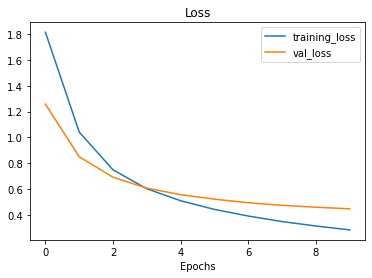

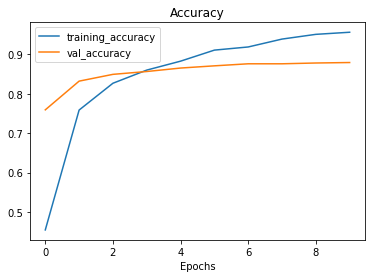

In [15]:
plot_loss_curves(eff_history)

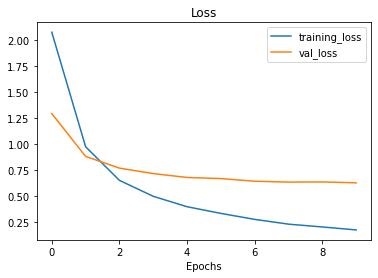

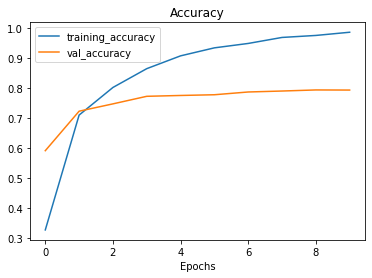

In [16]:
plot_loss_curves(resnet_history)